## SARIMA Implementation

In [26]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [27]:
df = pd.read_csv('../data/AAPL.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,03-01-2012,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,04-01-2012,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,05-01-2012,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,06-01-2012,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,09-01-2012,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
...,...,...,...,...,...,...,...
2006,23-12-2019,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2007,24-12-2019,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2008,26-12-2019,284.820007,289.980011,284.700012,289.910004,287.923645,23280300
2009,27-12-2019,291.119995,293.970001,288.119995,289.799988,287.814392,36566500


### Data Preprocessing

In [28]:
# Converting Date Column to DateTime Format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [29]:
# Setting Datetime as Index
dt = df.set_index('Date').rename_axis(None)
dt

,Open,High,Low,Close,Adj Close,Volume
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
...,...,...,...,...,...,...
2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300
2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500


In [30]:
# Standardizing the Data
from sklearn.preprocessing import StandardScaler

# Initializing Standard Scaler
scaler = StandardScaler()

# Applying Standard Scaler to only necessary features
scaled_data = scaler.fit_transform(dt[['Close']])
scaled_df = pd.DataFrame(scaled_data, columns=['Close'])
scaled_df.index = dt.index
scaled_df

,Close
2012-01-03,-1.344666
2012-01-04,-1.338422
2012-01-05,-1.325455
2012-01-06,-1.313109
2012-01-09,-1.315001
...,...
2019-12-23,3.109983
2019-12-24,3.115323
2019-12-26,3.226861
2019-12-27,3.224685


Standardizing data ensures that the data is on consistent scale, improving the performance and reliability of various algorithms, enhancing interpretability, and preventing numerical issues.

### Model Building

#### SARIMA

An SARIMA model is characterized by 4 terms (p, d, q) and Seasonality:

* p is the order of the AR term. It refers to the number of lags to be used as predictors.
* d is the number of differencing required to make the time series stationary
* q is the order of the MA term. It refers to the number of lagged forecast errors that should go into the ARIMA model.
* m is the number of observations per year.

Similar to ARIMA, the p,d,q values for seasonal parts of the model can be deduced from the ACF and PACF plots of the data.

#### Stationarity

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times.

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our SARIMA model.

#### ADF test

We will use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

#### Hypothesis Test: To evaluate Stationarity

Null Hypothesis: Time series is non-stationary.\
Alternative Hypothesis: Time series is Stationary.

So, if the p-value of the test is less than the significance level of 0.05,
then we can reject the null hypothesis and infer that the time series is indeed stationary.

In [31]:
# Hypothesis Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(scaled_df)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print("\nAccept Null Hypothesis: Data is non-stationary")
else:
    print("\nReject Null Hypothesis: Data is stationary")

ADF Statistic: 1.2193701254377973
p-value: 0.9961170178032009

Accept Null Hypothesis: Data is non-stationary


So, in our case, te p-value is > 0.05,\
we will need to find the order of differencing.

#### Getting Order of Differencing

In [32]:
from pmdarima.arima.utils import ndiffs

print('Differencing (d) =', ndiffs(scaled_df, test='adf'))

Differencing (d) = 1


#### Getting the order of AutoRegressive Model (q)

q is the order of the AR term. It refers to the number of lags to be used as predictors.

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial auto correlation represents the correlation between the series and its lags.

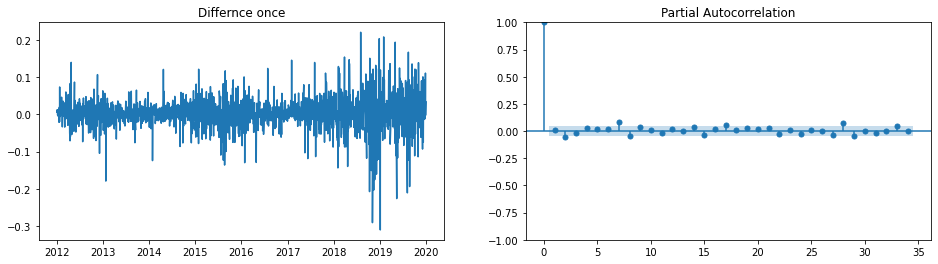

In [33]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

diff = scaled_df.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Differnce once')
ax2.set_ylim(0,1)
plot_pacf(diff, ax=ax2);

We can observe that the PACF lag (q) 2 is significant as it is above the significance line.

Therefore, we will consider q = 2.

#### Getting order of Moving Average.

p is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA model.

We can look at the ACF plot for the number of MA terms.

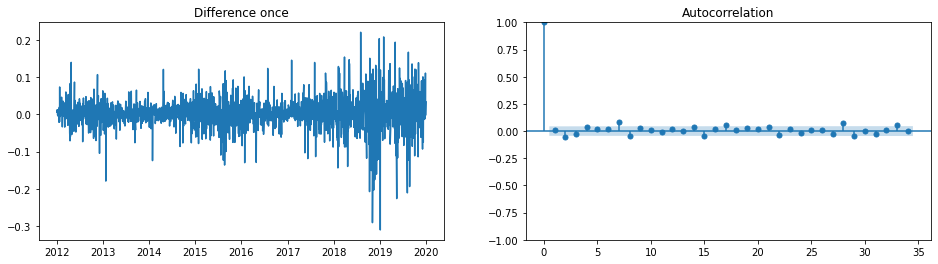

In [34]:
from statsmodels.graphics.tsaplots import plot_acf
diff = scaled_df.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0,1)
plot_acf(diff, ax=ax2);

The ACF lag (p) 1 is significant as it is just at the significance line.

So, we will consider p = 1.

#### Fitting Model

In [35]:
# Splitting the dataset
train_size = int(len(scaled_df) * 0.80) # 80% split

train, test = scaled_df.iloc[:train_size], scaled_df[train_size:]

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train,
    order=(1,1,2), # order=(p,d,q)
    seasonal_order=(0,0,0,12)
)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1608
Model:               SARIMAX(1, 1, 2)   Log Likelihood                3221.232
Date:                Wed, 03 Jul 2024   AIC                          -6434.465
Time:                        16:05:17   BIC                          -6412.936
Sample:                             0   HQIC                         -6426.472
                               - 1608                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1432      0.875     -0.164      0.870      -1.858       1.572
ma.L1          0.1858      0.875      0.212      0.832      -1.530       1.901
ma.L2         -0.0173      0.043     -0.404      0.686      -0.101       0.067
sigma2         0.0011   2.25e-05     47.181      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               963.05
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
predictions = model_fit.forecast(steps=int(len(test)))

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 0.5021438811989334
Mean Squared Error: 0.4531569809432877


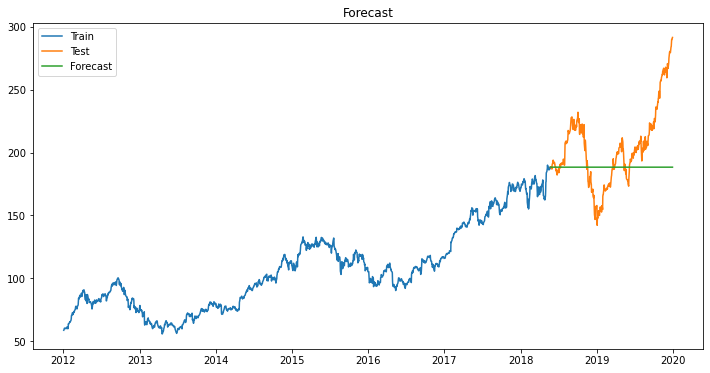

In [39]:
forecast = model_fit.forecast(steps=int(len(test)))
forecast_values = scaler.inverse_transform(forecast.values.reshape(-1,1))
forecasts_df = pd.DataFrame(forecast_values, index=test.index, columns=['Forecast'])

original_train = dt.iloc[:train_size]
original_test = dt.iloc[train_size:]


# Plotting forecast
plt.figure(figsize=(12, 6))
plt.plot(original_train.index, original_train['Close'], label='Train')
plt.plot(original_test.index, original_test['Close'], label='Test')
plt.plot(forecasts_df.index, forecasts_df['Forecast'], label='Forecast')
plt.title('Forecast')
plt.legend()
plt.show()


### Model Evaluation

Checking the residual to ensure they behave like white noise.

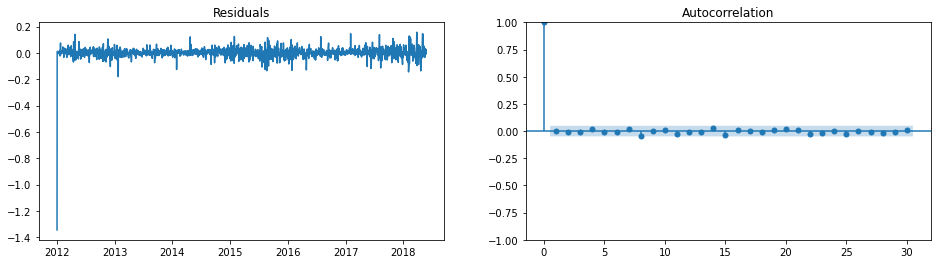

In [40]:
residuals = model_fit.resid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(residuals)
ax1.set_title('Residuals')
ax2.set_ylim(0,1)
plot_acf(residuals, lags=30, ax=ax2);

#### Making Forecasts

In [41]:
model = SARIMAX(
    scaled_df,
    order=(1,1,2), # order=(p,d,q)
    seasonal_order=(0,0,0,12)
)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2011
Model:               SARIMAX(1, 1, 2)   Log Likelihood                3516.372
Date:                Wed, 03 Jul 2024   AIC                          -7024.745
Time:                        16:05:18   BIC                          -7002.321
Sample:                             0   HQIC                         -7016.513
                               - 2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2497      0.330      0.756      0.450      -0.398       0.897
ma.L1         -0.2358      0.331     -0.712      0.477      -0.885       0.414
ma.L2         -0.0476      0.017     -2.864      0.004      -0.080      -0.015
sigma2         0.0018   2.79e-05     63.475      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3565.65
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               5.22   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

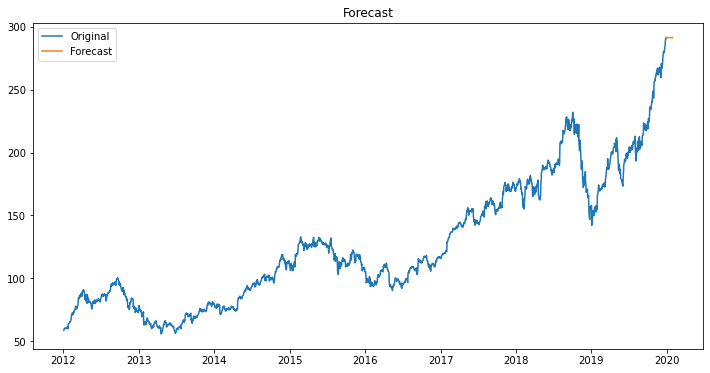

In [42]:
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)
forecast_values = scaler.inverse_transform(forecast.values.reshape(-1,1))

forecasts_dates = pd.date_range(
    start = dt.index[-1] + pd.Timedelta(days=1),
    periods=forecast_steps,
    freq='D'
)
forecasts_df = pd.DataFrame(forecast_values, index=forecasts_dates, columns=['Forecast'])

# Plotting forecast
plt.figure(figsize=(12, 6))
plt.plot(dt.index, dt['Close'], label='Original')
plt.plot(forecasts_df.index, forecasts_df['Forecast'], label='Forecast')
plt.title('Forecast')
plt.legend()
plt.show()

### Hyperparameter Tuning

Using pmdarima

In [43]:
import pmdarima as pm

In [44]:
# Performing grid search for ARIMA

optimized_model = pm.auto_arima(
    train,
    start_p=1,
    start_q=1,
    test='adf', # adf test to find optimal 'd'
    max_p=5,
    max_q=5,
    m=12,
    start_P=0,
    seasonal=True,
    d=None,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

optimized_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=14.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-2361.796, Time=0.42 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-5766.653, Time=6.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-3866.876, Time=4.66 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-2321.280, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-5287.960, Time=0.38 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-5946.992, Time=16.35 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=26.57 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=11.90 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-2363.574, Time=3.87 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-5959.032, Time=21.86 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-5777.838, Time=9.31 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=20.32 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=12.42 sec
 ARIMA(3,0,0)(2,1,0)[12] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1608
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                2985.836
Date:                             Wed, 03 Jul 2024   AIC                          -5959.672
Time:                                     16:10:40   BIC                          -5927.421
Sample:                                          0   HQIC                         -5947.695
                                            - 1608                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.001      1.741      0.082      -0.000       0.004
ar.L1          0.9556      0.007    135.022      0.000       0.942       0.969
ma.L1          0.1014      0.022      4.610      0.000       0.058       0.144
ar.S.L12      -0.6949      0.022    -30.920      0.000      -0.739      -0.651
ar.S.L24      -0.3405      0.021    -16.063      0.000      -0.382      -0.299
sigma2         0.0014   3.26e-05     42.362      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               433.95
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
sarima_order = optimized_model.order
seasonal_order = optimized_model.seasonal_order

print(f'Best SARIMA order: {sarima_order}')
print(f'Best SARIMA seasonal order: {seasonal_order}')

Best SARIMA order: (1, 0, 1)
Best SARIMA seasonal order: (2, 1, 0, 12)


#### Building Model using Optimized ARIMA Model

In [46]:
final_model = SARIMAX(
    scaled_df,
    order=(1, 0, 1), # order=(p,d,q)
    seasonal_order=(2, 1, 0, 12)
) 
final_model_fit = final_model.fit()
final_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 2011
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                3208.299
Date:                             Wed, 03 Jul 2024   AIC                          -6406.598
Time:                                     16:10:45   BIC                          -6378.596
Sample:                                          0   HQIC                         -6396.316
                                            - 2011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9700      0.004    239.843      0.000       0.962       0.978
ma.L1          0.0397      0.017      2.378      0.017       0.007       0.072
ar.S.L12      -0.6322      0.016    -38.847      0.000      -0.664      -0.600
ar.S.L24      -0.3179      0.015    -21.442      0.000      -0.347      -0.289
sigma2         0.0024    3.9e-05     60.310      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2642.76
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               5.11   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Making Forecasts

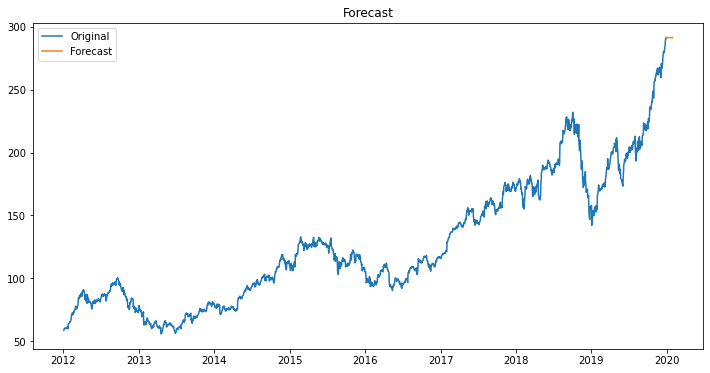

In [47]:
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)
forecast_values = scaler.inverse_transform(forecast.values.reshape(-1,1))

forecasts_dates = pd.date_range(
    start = dt.index[-1] + pd.Timedelta(days=1),
    periods=forecast_steps,
    freq='D'
)
forecasts_df = pd.DataFrame(forecast_values, index=forecasts_dates, columns=['Forecast'])

# Plotting forecast
plt.figure(figsize=(12, 6))
plt.plot(dt.index, dt['Close'], label='Original')
plt.plot(forecasts_df.index, forecasts_df['Forecast'], label='Forecast')
plt.title('Forecast')
plt.legend()
plt.show()